In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('/content/drive/MyDrive/DF_for_ml/2025_11_26_eda_final_ecg_data.csv', low_memory=False)

In [3]:
categorical_columns = ['heart_axis_norm', 'V1_pathological_Q']
numeric_columns = ['age', 'I_prop_censored', 'II_wavelet_entropy', 'II_SNR_dB', 'III_PSD_std_freq', 'III_wavelet_E2', 'AVR_RMSSD', 'AVR_STFT_energy', 'AVR_SNR_dB', 'AVR_prop_censored', 'AVL_STFT_energy', 'AVL_SNR_dB', 'AVF_SNR_dB', 'V1_RMSSD', 'V1_STFT_energy', 'V1_wavelet_entropy', 'V1_SNR_dB', 'V2_STFT_energy', 'V2_SNR_dB', 'V2_Q_wave_amp', 'V3_STFT_energy', 'V3_SNR_dB', 'V3_Q_wave_amp', 'V4_STFT_energy', 'V4_SNR_dB', 'V5_SNR_dB', 'V5_prop_censored', 'V5_Q_wave_amp', 'V6_STFT_energy', 'V6_SNR_dB', 'V6_prop_censored', 'meanRR_global', 'V3_PSD_mean_freq', 'V5_PSD_std_freq', 'AVF_wavelet_E5', 'I_wavelet_E5', 'I_wavelet_entropy']
target_columns = ['target_norm', 'target_arrhythmia', 'target_infarction']

In [5]:
X = df.drop(columns=target_columns)
y = df['target_norm']

In [6]:
#Ячейка кода написана с помощью ChatGPT
from sklearn.ensemble import IsolationForest
from scipy import stats

# numeric_columns — твой список признаков

def analyze_feature_anomalies(X, y, numeric_columns):
    """
    Анализ аномалий по каждому признаку:
    Z-score, IQR, IsolationForest (1D), Range-based.
    Возвращает таблицу с диагностикой.
    """

    results = []

    for feature in numeric_columns:
        if feature not in X.columns:
            continue

        col = X[feature].astype(float)

        # --- 1. Z-score ---
        z_scores = np.abs(stats.zscore(col, nan_policy='omit'))
        z_anom = z_scores > 3  # классический порог
        z_pct = z_anom.mean() * 100

        # --- 2. IQR ---
        Q1, Q3 = col.quantile(0.25), col.quantile(0.75)
        IQR = Q3 - Q1
        iqr_low = Q1 - 1.5 * IQR
        iqr_high = Q3 + 1.5 * IQR
        iqr_anom = (col < iqr_low) | (col > iqr_high)
        iqr_pct = iqr_anom.mean() * 100

        # --- 3. IsolationForest (one-dimensional) ---
        iso = IsolationForest(contamination=0.05, random_state=42)
        iso_pred = iso.fit_predict(col.values.reshape(-1, 1))
        iso_anom = iso_pred == -1
        iso_pct = iso_anom.mean() * 100

        # --- 4. Range-based anomalies (min/max jump) ---
        lower_q = col.quantile(0.01)
        upper_q = col.quantile(0.99)
        range_anom = (col < lower_q) | (col > upper_q)
        range_pct = range_anom.mean() * 100

        # -----------------------------
        #   Связь аномалий с классами
        # -----------------------------

        def pct_in_class(mask, cls):
            return mask[y == cls].mean() * 100 if (y == cls).sum() > 0 else 0

        results.append({
            'feature': feature,

            # Частота аномалий
            'z_pct': z_pct,
            'iqr_pct': iqr_pct,
            'iso_pct': iso_pct,
            'range_pct': range_pct,

            # IQR: корреляция с классами
            'iqr_sick_pct': pct_in_class(iqr_anom, 0),
            'iqr_healthy_pct': pct_in_class(iqr_anom, 1),

            # IsolationForest: связь с классами
            'iso_sick_pct': pct_in_class(iso_anom, 0),
            'iso_healthy_pct': pct_in_class(iso_anom, 1),

            # Z-score: связь с классами
            'z_sick_pct': pct_in_class(z_anom, 0),
            'z_healthy_pct': pct_in_class(z_anom, 1),

            # Range-based
            'range_sick_pct': pct_in_class(range_anom, 0),
            'range_healthy_pct': pct_in_class(range_anom, 1),
        })

    return pd.DataFrame(results)


# ---- Запуск анализа ----

print("Выполняю анализ аномалий по всем признакам...")
feature_anomaly_report = analyze_feature_anomalies(X, y, numeric_columns)

# Таблица в порядке убывания доли аномалий
feature_anomaly_report_sorted = feature_anomaly_report.sort_values(by='iso_pct', ascending=False)
feature_anomaly_report_sorted


Выполняю анализ аномалий по всем признакам...


,feature,z_pct,iqr_pct,iso_pct,range_pct,iqr_sick_pct,iqr_healthy_pct,iso_sick_pct,iso_healthy_pct,z_sick_pct,z_healthy_pct,range_sick_pct,range_healthy_pct
2,II_wavelet_entropy,1.552129,4.053916,5.003574,2.001430,6.421170,1.139212,7.346410,2.118934,2.350111,0.569606,2.831236,0.979722
3,II_SNR_dB,0.326764,0.490146,5.003574,2.001430,0.610659,0.341763,6.439674,3.235361,0.370096,0.273411,2.794226,1.025290
8,AVR_SNR_dB,0.347187,0.612683,5.003574,2.001430,0.592154,0.637959,6.125093,3.622693,0.314582,0.387332,2.590674,1.275917
7,AVR_STFT_energy,0.673951,5.473297,5.003574,2.001430,7.216876,3.326498,7.253886,2.232855,0.925241,0.364548,3.182828,0.546822
5,III_wavelet_E2,1.746145,10.660676,5.003574,2.001430,17.801628,1.868307,8.845300,0.273411,3.127313,0.045568,2.331606,1.594896
35,I_wavelet_E5,1.347902,5.330338,5.003574,2.001430,6.661732,3.691046,6.421170,3.258145,1.905996,0.660743,2.905255,0.888585
29,V6_SNR_dB,0.296130,0.388032,5.003574,2.001430,0.351591,0.432900,5.625463,4.237867,0.277572,0.318979,2.239082,1.708817
32,V3_PSD_mean_freq,0.081691,0.122537,5.003574,2.001430,0.203553,0.022784,7.105848,2.415129,0.129534,0.022784,2.886751,0.911369
15,V1_wavelet_entropy,1.909527,4.932094,5.003574,2.001430,6.754256,2.688540,6.143597,3.599909,2.072539,1.708817,1.961510,2.050581
20,V3_STFT_energy,1.123251,9.639538,5.003574,2.001430,14.322724,3.873320,7.790526,1.572112,1.776462,0.318979,2.720207,1.116427


Создание очищенных датасетов...

Сравнение распределений...
СРАВНЕНИЕ РАСПРЕДЕЛЕНИЙ ДО И ПОСЛЕ ОЧИСТКИ

ИСХОДНЫЕ ДАННЫЕ:
Всего записей: 9793
Распределение по классам:
  Класс 0: 5404 записей (55.18%)
  Класс 1: 4389 записей (44.82%)

МЕТОД                УДАЛЕНО      ОСТАЛОСЬ     ИЗМЕНЕНИЕ БАЛАНСА
------------------------------------------------------------
z_score              1779     (18.2%)  8014         8.12%
    Класс 0: -4.06%
    Класс 1: +4.06%
iqr                  5647     (57.7%)  4146         28.60%
    Класс 0: -14.30%
    Класс 1: +14.30%
isolation_forest     6385     (65.2%)  3408         29.09%
    Класс 0: -14.54%
    Класс 1: +14.54%
range_based          3778     (38.6%)  6015         16.00%
    Класс 0: -8.00%
    Класс 1: +8.00%


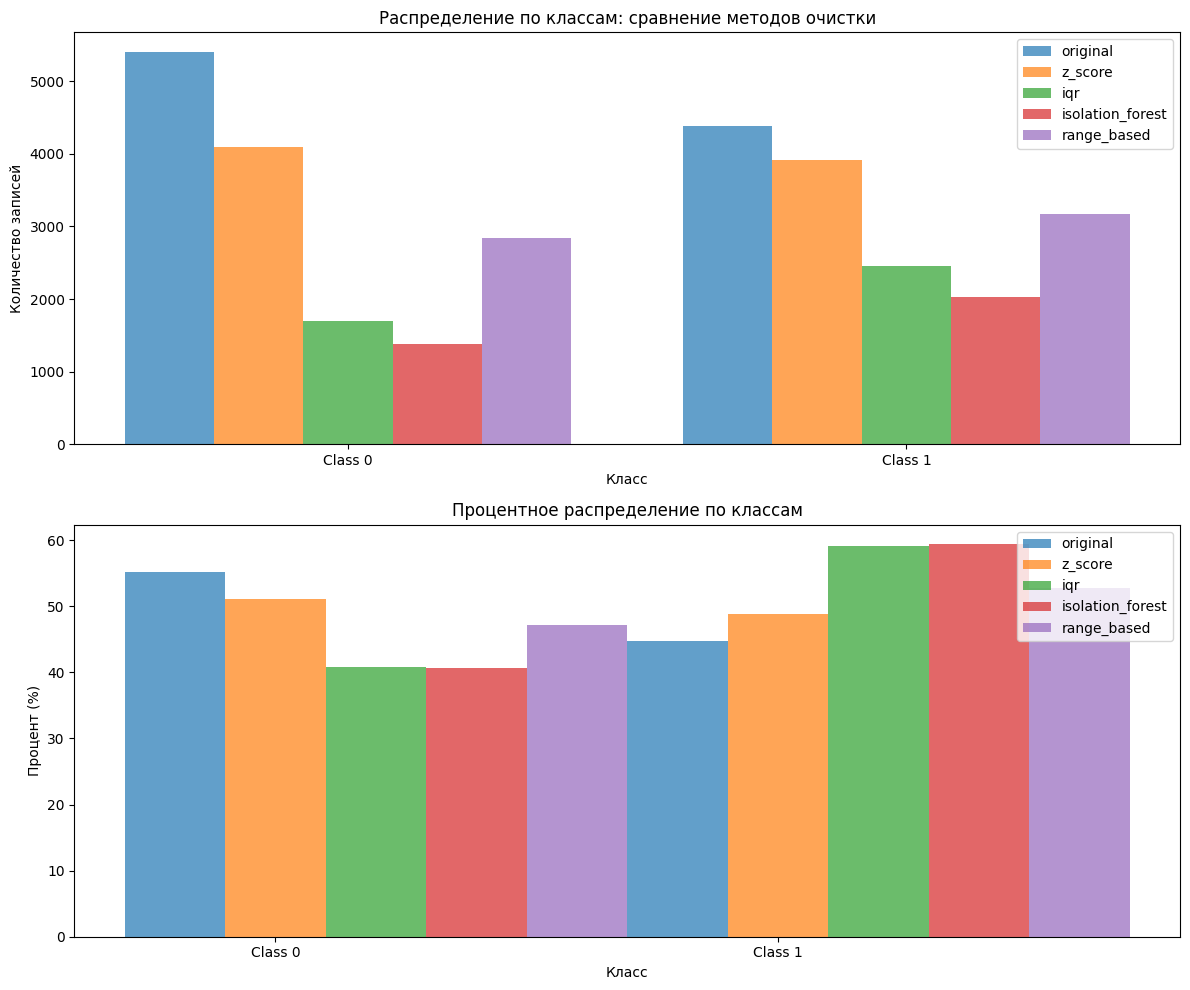


Очищенные датафреймы созданы:
Z-score: 8014 записей
IQR: 4146 записей
Isolation Forest: 3408 записей
Range-based: 6015 записей


In [7]:
#ячейка кода написана с помощью Deepseek
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from scipy import stats

def create_clean_datasets(X, y, numeric_columns):
    """
    Создает очищенные датафреймы разными методами детекции аномалий
    Возвращает словарь с очищенными данными и информацию об удаленных записях
    """

    clean_datasets = {}
    removal_info = {}

    # Исходные данные
    original_data = pd.concat([X[numeric_columns], y], axis=1)
    original_count = len(original_data)

    # --- 1. Z-score метод (|Z| > 3) ---
    z_anomalies_mask = pd.Series(False, index=X.index)
    for feature in numeric_columns:
        if feature in X.columns:
            z_scores = np.abs(stats.zscore(X[feature].astype(float), nan_policy='omit'))
            z_anomalies_mask |= (z_scores > 3)

    z_clean_mask = ~z_anomalies_mask
    df_z_clean = original_data[z_clean_mask].copy()
    clean_datasets['z_score'] = df_z_clean
    removal_info['z_score'] = {
        'removed_count': z_anomalies_mask.sum(),
        'removed_percentage': (z_anomalies_mask.sum() / original_count) * 100,
        'remaining_count': len(df_z_clean)
    }

    # --- 2. IQR метод ---
    iqr_anomalies_mask = pd.Series(False, index=X.index)
    for feature in numeric_columns:
        if feature in X.columns:
            col = X[feature].astype(float)
            Q1, Q3 = col.quantile(0.25), col.quantile(0.75)
            IQR = Q3 - Q1
            iqr_low = Q1 - 1.5 * IQR
            iqr_high = Q3 + 1.5 * IQR
            iqr_anomalies_mask |= (col < iqr_low) | (col > iqr_high)

    iqr_clean_mask = ~iqr_anomalies_mask
    df_iqr_clean = original_data[iqr_clean_mask].copy()
    clean_datasets['iqr'] = df_iqr_clean
    removal_info['iqr'] = {
        'removed_count': iqr_anomalies_mask.sum(),
        'removed_percentage': (iqr_anomalies_mask.sum() / original_count) * 100,
        'remaining_count': len(df_iqr_clean)
    }

    # --- 3. Isolation Forest ---
    iso_anomalies_mask = pd.Series(False, index=X.index)
    for feature in numeric_columns:
        if feature in X.columns:
            col = X[feature].astype(float).values.reshape(-1, 1)
            iso = IsolationForest(contamination=0.05, random_state=42)
            iso_pred = iso.fit_predict(col)
            iso_anomalies_mask |= (iso_pred == -1)

    iso_clean_mask = ~iso_anomalies_mask
    df_iso_clean = original_data[iso_clean_mask].copy()
    clean_datasets['isolation_forest'] = df_iso_clean
    removal_info['isolation_forest'] = {
        'removed_count': iso_anomalies_mask.sum(),
        'removed_percentage': (iso_anomalies_mask.sum() / original_count) * 100,
        'remaining_count': len(df_iso_clean)
    }

    # --- 4. Range-based (1-99 percentile) ---
    range_anomalies_mask = pd.Series(False, index=X.index)
    for feature in numeric_columns:
        if feature in X.columns:
            col = X[feature].astype(float)
            lower_q = col.quantile(0.01)
            upper_q = col.quantile(0.99)
            range_anomalies_mask |= (col < lower_q) | (col > upper_q)

    range_clean_mask = ~range_anomalies_mask
    df_range_clean = original_data[range_clean_mask].copy()
    clean_datasets['range_based'] = df_range_clean
    removal_info['range_based'] = {
        'removed_count': range_anomalies_mask.sum(),
        'removed_percentage': (range_anomalies_mask.sum() / original_count) * 100,
        'remaining_count': len(df_range_clean)
    }

    return clean_datasets, removal_info, original_data

def compare_distributions(original_data, clean_datasets, target_column):
    """
    Сравнивает распределение целевой переменной до и после очистки
    """

    comparison_results = {}

    # Исходное распределение
    original_dist = original_data[target_column].value_counts().sort_index()
    original_percentage = (original_dist / len(original_data)) * 100

    comparison_results['original'] = {
        'counts': original_dist,
        'percentages': original_percentage,
        'total_count': len(original_data)
    }

    # Распределение после каждой очистки
    for method, clean_data in clean_datasets.items():
        clean_dist = clean_data[target_column].value_counts().sort_index()
        clean_percentage = (clean_dist / len(clean_data)) * 100

        comparison_results[method] = {
            'counts': clean_dist,
            'percentages': clean_percentage,
            'total_count': len(clean_data),
            'change_vs_original': clean_percentage - original_percentage
        }

    return comparison_results

def plot_distribution_comparison(comparison_results, target_name='target'):
    """
    Визуализирует сравнение распределений
    """

    methods = list(comparison_results.keys())
    n_methods = len(methods)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

    # График абсолютных количеств
    x_pos = np.arange(len(comparison_results['original']['counts']))
    width = 0.8 / n_methods

    for i, method in enumerate(methods):
        offsets = i * width - (n_methods - 1) * width / 2
        counts = comparison_results[method]['counts']
        ax1.bar(x_pos + offsets, counts, width, label=method, alpha=0.7)

    ax1.set_xlabel('Класс')
    ax1.set_ylabel('Количество записей')
    ax1.set_title('Распределение по классам: сравнение методов очистки')
    ax1.legend()
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels([f'Class {cls}' for cls in comparison_results['original']['counts'].index])

    # График процентных соотношений
    for i, method in enumerate(methods):
        percentages = comparison_results[method]['percentages']
        ax2.bar(x_pos + i * 0.2, percentages, 0.2, label=method, alpha=0.7)

    ax2.set_xlabel('Класс')
    ax2.set_ylabel('Процент (%)')
    ax2.set_title('Процентное распределение по классам')
    ax2.legend()
    ax2.set_xticks(x_pos + 0.2)
    ax2.set_xticklabels([f'Class {cls}' for cls in comparison_results['original']['counts'].index])

    plt.tight_layout()
    plt.show()

def print_comparison_summary(comparison_results, removal_info):
    """
    Выводит сводную информацию по сравнению
    """

    print("=" * 60)
    print("СРАВНЕНИЕ РАСПРЕДЕЛЕНИЙ ДО И ПОСЛЕ ОЧИСТКИ")
    print("=" * 60)

    original = comparison_results['original']
    print(f"\nИСХОДНЫЕ ДАННЫЕ:")
    print(f"Всего записей: {original['total_count']}")
    print("Распределение по классам:")
    for cls in original['counts'].index:
        print(f"  Класс {cls}: {original['counts'][cls]} записей ({original['percentages'][cls]:.2f}%)")

    print(f"\n{'МЕТОД':<20} {'УДАЛЕНО':<12} {'ОСТАЛОСЬ':<12} {'ИЗМЕНЕНИЕ БАЛАНСА'}")
    print("-" * 60)

    for method in removal_info.keys():
        if method in comparison_results:
            removed_pct = removal_info[method]['removed_percentage']
            remaining = removal_info[method]['remaining_count']
            changes = comparison_results[method]['change_vs_original']

            # Суммарное изменение баланса (абсолютные значения изменений)
            balance_change = sum(abs(changes))

            print(f"{method:<20} {removal_info[method]['removed_count']:<8} ({removed_pct:.1f}%)  "
                  f"{remaining:<12} {balance_change:.2f}%")

            # Детали по классам
            for cls in changes.index:
                change = changes[cls]
                if abs(change) > 0.1:  # Показываем только значительные изменения
                    print(f"    Класс {cls}: {change:+.2f}%")

# --- ЗАПУСК АНАЛИЗА ---

# Предполагая, что y - это Series с целевой переменной
target_column = y.name if hasattr(y, 'name') else 'target'

print("Создание очищенных датасетов...")
clean_datasets, removal_info, original_data = create_clean_datasets(X, y, numeric_columns)

print("\nСравнение распределений...")
comparison_results = compare_distributions(original_data, clean_datasets, target_column)

# Вывод результатов
print_comparison_summary(comparison_results, removal_info)

# Визуализация
plot_distribution_comparison(comparison_results, target_column)

# Возвращаем очищенные датафреймы для дальнейшего использования
df_clean_z = clean_datasets['z_score']
df_clean_iqr = clean_datasets['iqr']
df_clean_iso = clean_datasets['isolation_forest']
df_clean_range = clean_datasets['range_based']

print(f"\nОчищенные датафреймы созданы:")
print(f"Z-score: {len(df_clean_z)} записей")
print(f"IQR: {len(df_clean_iqr)} записей")
print(f"Isolation Forest: {len(df_clean_iso)} записей")
print(f"Range-based: {len(df_clean_range)} записей")

ДЕТАЛЬНЫЙ АНАЛИЗ УДАЛЕНИЯ ПО КЛАССАМ
Исходное распределение:
  Класс 0: 5404 записей (55.2%)
  Класс 1: 4389 записей (44.8%)

МЕТОД: Z_SCORE
  Всего удалено: 1779 записей
  Удалено из класса 0: 1307 (24.2%)
  Удалено из класса 1: 472 (10.8%)
  Разница: +13.4%

МЕТОД: IQR
  Всего удалено: 5647 записей
  Удалено из класса 0: 3709 (68.6%)
  Удалено из класса 1: 1938 (44.2%)
  Разница: +24.5%

МЕТОД: ISOLATION_FOREST
  Всего удалено: 6385 записей
  Удалено из класса 0: 4019 (74.4%)
  Удалено из класса 1: 2366 (53.9%)
  Разница: +20.5%

МЕТОД: RANGE_BASED
  Всего удалено: 3778 записей
  Удалено из класса 0: 2566 (47.5%)
  Удалено из класса 1: 1212 (27.6%)
  Разница: +19.9%



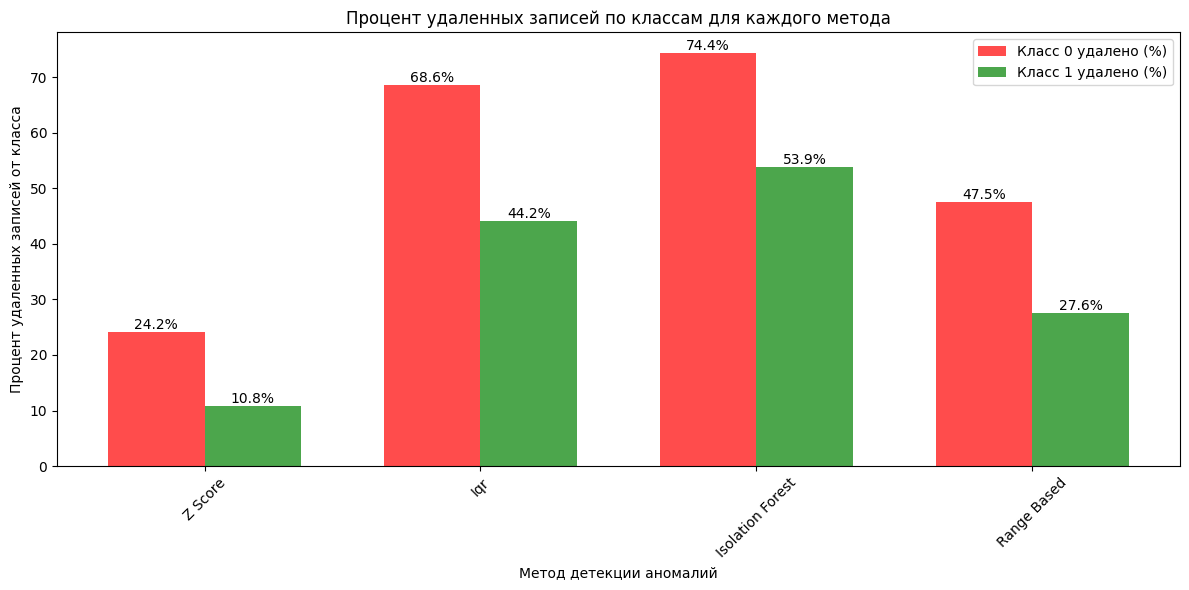

ПРОВЕРКА СТАТИСТИЧЕСКОЙ ЗНАЧИМОСТИ

Z_SCORE:
  p-value = 0.000000
  Статистически значимо: ДА
  ★ Метод значимо смещен в удалении одного из классов!

IQR:
  p-value = 0.000000
  Статистически значимо: ДА
  ★ Метод значимо смещен в удалении одного из классов!

ISOLATION_FOREST:
  p-value = 0.000000
  Статистически значимо: ДА
  ★ Метод значимо смещен в удалении одного из классов!

RANGE_BASED:
  p-value = 0.000000
  Статистически значимо: ДА
  ★ Метод значимо смещен в удалении одного из классов!


In [8]:
#ячейка кода написана с помощью Deepsee
def detailed_removal_analysis(X, y, clean_datasets, removal_info):
    """
    Детальный анализ того, какие классы удаляются каждым методом
    """
    original_class_counts = y.value_counts()

    print("ДЕТАЛЬНЫЙ АНАЛИЗ УДАЛЕНИЯ ПО КЛАССАМ")
    print("=" * 70)
    print(f"Исходное распределение:")
    print(f"  Класс 0: {original_class_counts[0]} записей ({original_class_counts[0]/len(y)*100:.1f}%)")
    print(f"  Класс 1: {original_class_counts[1]} записей ({original_class_counts[1]/len(y)*100:.1f}%)")
    print()

    removal_by_class = {}

    for method, clean_data in clean_datasets.items():
        # Определяем какие записи были удалены
        original_indices = set(X.index)
        clean_indices = set(clean_data.index)
        removed_indices = original_indices - clean_indices

        # Анализируем классы удаленных записей
        removed_y = y.loc[list(removed_indices)]
        removed_class_counts = removed_y.value_counts()

        # Процент удаления от исходного количества в каждом классе
        pct_removed_class0 = (removed_class_counts.get(0, 0) / original_class_counts[0]) * 100
        pct_removed_class1 = (removed_class_counts.get(1, 0) / original_class_counts[1]) * 100

        removal_by_class[method] = {
            'removed_class0': removed_class_counts.get(0, 0),
            'removed_class1': removed_class_counts.get(1, 0),
            'pct_removed_class0': pct_removed_class0,
            'pct_removed_class1': pct_removed_class1,
            'difference': pct_removed_class0 - pct_removed_class1
        }

        print(f"МЕТОД: {method.upper()}")
        print(f"  Всего удалено: {removal_info[method]['removed_count']} записей")
        print(f"  Удалено из класса 0: {removed_class_counts.get(0, 0)} ({pct_removed_class0:.1f}%)")
        print(f"  Удалено из класса 1: {removed_class_counts.get(1, 0)} ({pct_removed_class1:.1f}%)")
        print(f"  Разница: {pct_removed_class0 - pct_removed_class1:+.1f}%")
        print()

    return removal_by_class

# Запускаем детальный анализ
removal_by_class = detailed_removal_analysis(X, y, clean_datasets, removal_info)

# Визуализация
def plot_removal_by_class(removal_by_class):
    methods = list(removal_by_class.keys())
    pct_class0 = [removal_by_class[method]['pct_removed_class0'] for method in methods]
    pct_class1 = [removal_by_class[method]['pct_removed_class1'] for method in methods]

    x = np.arange(len(methods))
    width = 0.35

    fig, ax = plt.subplots(figsize=(12, 6))
    bars1 = ax.bar(x - width/2, pct_class0, width, label='Класс 0 удалено (%)', alpha=0.7, color='red')
    bars2 = ax.bar(x + width/2, pct_class1, width, label='Класс 1 удалено (%)', alpha=0.7, color='green')

    ax.set_xlabel('Метод детекции аномалий')
    ax.set_ylabel('Процент удаленных записей от класса')
    ax.set_title('Процент удаленных записей по классам для каждого метода')
    ax.set_xticks(x)
    ax.set_xticklabels([m.replace('_', ' ').title() for m in methods])
    ax.legend()

    # Добавляем подписи на столбцы
    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}%', ha='center', va='bottom')

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_removal_by_class(removal_by_class)

# Анализ статистической значимости
from scipy.stats import chi2_contingency

def statistical_significance_test(X, y, clean_datasets):
    """
    Проверяет статистическую значимость различий в удалении по классам
    """
    print("ПРОВЕРКА СТАТИСТИЧЕСКОЙ ЗНАЧИМОСТИ")
    print("=" * 50)

    for method, clean_data in clean_datasets.items():
        # Создаем таблицу сопряженности
        original_class_counts = y.value_counts().sort_index()
        clean_class_counts = clean_data[y.name].value_counts().sort_index()
        removed_class_counts = original_class_counts - clean_class_counts

        # Таблица: [удалено_класс0, удалено_класс1; оставлено_класс0, оставлено_класс1]
        contingency_table = np.array([
            [removed_class_counts[0], removed_class_counts[1]],
            [clean_class_counts[0], clean_class_counts[1]]
        ])

        chi2, p_value, dof, expected = chi2_contingency(contingency_table)

        print(f"\n{method.upper()}:")
        print(f"  p-value = {p_value:.6f}")
        print(f"  Статистически значимо: {'ДА' if p_value < 0.05 else 'НЕТ'}")
        if p_value < 0.05:
            print(f"  ★ Метод значимо смещен в удалении одного из классов!")

statistical_significance_test(X, y, clean_datasets)